In [50]:
%run ../talktools.py

In [ ]:
# some of this notebook from http://bit.ly/15WsUXU
!pip install sqlalchemy

# ORMs: SQLAlchemy

ORM “Object Relational Mapper”

- associates Python classes with database tables, and instances of those classes (objects) with rows in their corresponding tables.

- “high level and abstracted pattern of usage”

- essentially, making the Python usage almost entirely independent of the database engine 

http://docs.sqlalchemy.org/en/latest/index.html


### Create an engine. 

For this demo we're using SQLite in memory, and echoing the SQL as it's executed. However, SQLAlchemy can use a number of DBs in the backend ("dialects"):

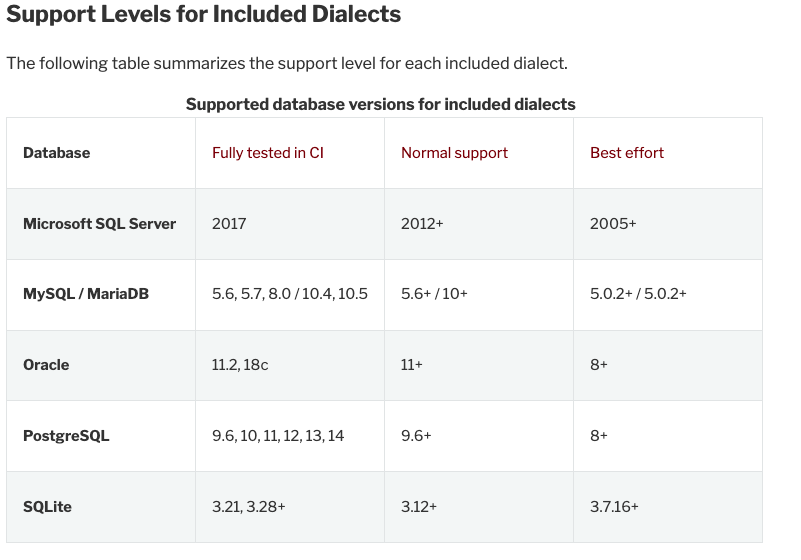

In [ ]:
import sqlalchemy
sqlalchemy.__version__ 

In [ ]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///:memory:')

### Core (non ORM): functionality Let's declare a basic table

In [ ]:
from sqlalchemy import *
metadata = MetaData()

vehicles_table = Table('vehicles', metadata,
                       Column('model', String),
                       Column('registration', String),
                       Column('odometer', Integer),
                       Column('last_service', Date),)
vehicles_table

### The table doesn't exist yet, so let's create it

In [ ]:
vehicles_table.create(bind=engine)

### SQLAlchemy core's main job is to generate SQL

In [ ]:
query = vehicles_table.select()
print("type:",type(query))
print("query:",query)

### The _select_ above is a shortcut for...

In [ ]:
query = select([vehicles_table])
print("type:",type(query))
print("query:",query)

### Access the table's column metadata

In [ ]:
vehicles_table.c.odometer

### Using method chaining we can add to the query. Note how column operators are overloaded to produce SQL

In [ ]:
query = query.where(vehicles_table.c.odometer < 10000)
print(query)

### Using the engine created earlier, let's now run our query

In [ ]:
results = engine.execute(query)
for row in results:
    print(row,end=" ")

### No results, let's insert some rows

In [ ]:
values = [
    { 'model': 'Ford Festiva', 'registration': 'HAX00R', 'odometer': 3141 },
    { 'model': 'Lotus Elise', 'registration': 'DELEG8', 'odometer': 31415 },
]
rows = engine.execute(vehicles_table.insert(), list(values)).rowcount
print(rows, "rows inserted")

### Try our query again

In [ ]:
results = engine.execute(query)
for row in results:
    print(row,end=" ")

### Trying something more elaborate, let's see the SQL for adding up the odometer readings by model 

In [ ]:
print(select([vehicles_table.c.model, 
              func.sum(vehicles_table.c.odometer).label('total_km')
             ]).group_by(vehicles_table.c.model))

### There's much much more we can do. Literal SQL, functions, joins, aliases, unions, ...

# ORM

In [ ]:
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship
Base = declarative_base()

class Person(Base):
    __tablename__ = 'people' # Choose your own table name!
    id = Column(Integer, primary_key=True)
    first_name = Column(String)
    last_name = Column(String)
    email = Column(String)
    birthday = Column(DateTime)
    appointments = relationship("Appointment", backref="person")

    def __init__(self, firstname, lastname, email):
        """ Constructor is optional """
        self.first_name = firstname
        self.last_name = lastname
        self.email = email

class Appointment(Base):
    __tablename__ = 'appointments'
    id = Column(Integer, primary_key=True)
    person_id = Column(Integer, ForeignKey('people.id')) # <-- Table name
    meeting_at = Column(DateTime)
    notes = Column(String)

In [ ]:
print(f"Underlying table object:\n {Person.__table__}")
print("*"*30)
print(f"What does the declarative base know?\n {Base.metadata.tables}")

In [ ]:
from sqlalchemy import inspect
insp = inspect(Person)
list(insp.columns)

### Create the table!

In [ ]:
Base.metadata.create_all(engine) 

### Now let's create a session

In [ ]:
from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=engine)
session = Session()

p = Person('newfirst', 'newlast', 'new@example.com');
session.add(p)

### The query below will cause the above addition to be automatically flushed.

In [ ]:
for p in session.query(Person):
    print(p.first_name)

### The ORM uses the underlying core to generate SQL

In [ ]:
print(session.query(Person).filter_by(id=1))

### Session queries can be built up to retrieve specific elements

In [ ]:
for row in session.query(Person, Person.first_name, Person.email.label('address')).filter_by(id=1):
    print("Person object:", row.Person)
    print("Selected attributes:", row.first_name, row.address)

### The session keeps track of objects and their state, so the exact same object is returned even via another query.

In [ ]:
queried_person = session.query(Person).filter_by(first_name='newfirst').first()

p is queried_person

### Queries are generative

In [ ]:
query = session.query(Person).filter(~Person.first_name.in_(['ed', 'wendy', 'jack']))
print(query)

### Additional filter criteria is added with an AND operator

In [ ]:
from datetime import datetime, timedelta
query = query.filter(Person.birthday < datetime.now() - timedelta(days=1))
print(query)

# Relationships

### Let's create an appointment related to our person

In [ ]:
appointment = Appointment(person=session.query(Person).first(),
                          notes="Appointment date TBC")
session.add(appointment)

### Now we can query from either end of the relationship

In [ ]:
for a in session.query(Appointment):
    print(a.person)

In [ ]:
for p in session.query(Person):
    print(p.appointments)